<a href="https://colab.research.google.com/github/pszemraj/ml4hc-s22-project01/blob/add-ensemble-results/notebooks/colab/ensemble/Ensembles_MITBIH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center> Basic Ensembling of Model Outputs </center>

<font color="orange"> - this one is for the MITBIH dataset </font>

In [1]:
#@title mount drive
from pathlib import Path
from google.colab import drive

drive_base_str = '/content/drive'
drive.mount(drive_base_str)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@markdown add auto-Colab formatting with `IPython.display`
from IPython.display import HTML, display
# colab formatting
def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )

get_ipython().events.register("pre_run_cell", set_css)

In [3]:
!pip install -U pandas -q
import pandas as pd

In [4]:
!python -m pip uninstall -y matplotlib
!pip install matplotlib==3.1.3 -q
import matplotlib.pyplot as plt

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Successfully uninstalled matplotlib-3.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.0 requires matplotlib>=3.2.0, but you have matplotlib 3.1.3 which is incompatible.
autoviz 0.1.36 requires matplotlib>=3.3.3, but you have matplotlib 3.1.3 which is incompatible.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
!pip install scikit-learn==0.23.2 -q
import sklearn

In [6]:
!pip install -U pycaret[full] -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.11.4 requires typing-extensions<4,>=3.7.4.3, but you have typing-extensions 4.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [7]:
!nvidia-smi

Tue Mar 29 01:01:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# setup

In [8]:
#@markdown add auto-Colab formatting with `IPython.display`
from IPython.display import HTML, display
# colab formatting
def set_css():
    display(
        HTML(
            """
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  """
        )
    )

get_ipython().events.register("pre_run_cell", set_css)

In [9]:
#@markdown determine root
import os
from pathlib import Path
peter_base = Path('/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/')

if peter_base.exists() and peter_base.is_dir():
    path = str(peter_base.resolve())
else:
    # original
    path = '/content/drive/MyDrive/ETH/'

print(f"base drive dir is:\n{path}")

base drive dir is:
/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1


## define folder for outputs

In [10]:
_out_dir_name = "Trained-Results-Analysis" #@param {type:"string"}

output_path = os.path.join(path, _out_dir_name)
os.makedirs(output_path, exist_ok=True)
print(f"notebook outputs will be stored in:\n{output_path}")

notebook outputs will be stored in:
/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/Trained-Results-Analysis


## util functions

In [11]:
import os
import time
import shutil
from google.colab import files
from os.path import join
# /content/SHAP summary.png
def grab_pycaret_export(filename:str, file_dir=None, new_name=None,
                        destination=None):
    """
    grab_pycaret_export - pycaret only saves the same filename to the local wd
                            which is a problem if you want multiple of the plot..
    """

    file_dir = os.getcwd() if file_dir is None else file_dir
    orig_path = join(file_dir, filename)

    if new_name is not None:
        new_path = join(file_dir, new_name)
        os.rename(orig_path, new_path)
    else:
        new_path = orig_path
        new_name = filename
    
    if destination is None:
        print(f"downloading {new_path}")
        time.sleep(2)
        files.download(new_path)
    else:
        shutil.move(new_path, join(destination, new_name))
        # shutil.copy(new_path, join(file_dir, new_name))
        print(f"moved file to {file_dir}")



In [12]:
# grab_pycaret_export('SHAP summary.png', new_name="export-test.png", 
#                     destination='/content/drive/MyDrive/Analysis')

# test basic ensembling with PyCaret

- docs can be found [here](https://pycaret.gitbook.io/docs/get-started/tutorials)


In [13]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


In [14]:
import pandas as pd 

In [15]:
root_dir = Path(path)
# /content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/Trained-Results-Analysis/mitbih_ensemble/mitbih_testset_model_predictions.csv
mitbih_result_path = root_dir / "Trained-Results-Analysis" / "MIT_ensemble" / "MITBIH_testset_model_predictions.csv"
mitbih_df = pd.read_csv(mitbih_result_path)

In [16]:
mitbih_outpath = Path(output_path) / "MIT_ensemble"
mit_figures = mitbih_outpath / "mit_figures"

mitbih_outpath.mkdir(exist_ok=True)
mit_figures.mkdir(exist_ok=True)

In [17]:
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


## setup experiment

In [18]:

from pycaret.classification import setup
mitbih_exp = setup(data = mitbih_df, target = 'actual_class', 
                   log_experiment = True, experiment_name = "mitbih_ensemble1",
                session_id=123, 
                use_gpu=True)
                

Description             Value
0                               session_id               123
1                                   Target      actual_class
2                              Target Type        Multiclass
3                            Label Encoded              None
4                            Original Data       (21892, 19)
5                           Missing Values             False
6                         Numeric Features                 0
7                     Categorical Features                18
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set       (15324, 78)
12                    Transformed Test Set        (6568, 78)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU              True
19                          Log Experiment              True
20                         Experiment Name  mitbih_ensemble1
21                                     USI              e057
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44             Remove Perfect Collinearity              True
45                              Clustering             False
46                    Clustering Iteration              None
47                     Polynomial Features             False
48                       Polynomial Degree              None
49                    Trignometry Features             False
50                    Polynomial Threshold              None
51                          Group Features             False
52                       Feature Selection             False
53                Feature Selection Method           classic
54            Features Selection Threshold              None
55                     Feature Interaction             False
56                           Feature Ratio             False
57                   Interaction Threshold              None
58                           Fix Imbalance             False
59                    Fix Imbalance Method             SMOTE

2022/03/29 01:01:35 INFO mlflow.tracking.fluent: Experiment with name 'mitbih_ensemble1' does not exist. Creating a new experiment.


In [19]:
# add metric
from sklearn.metrics import balanced_accuracy_score
add_metric('balanced_accuracy', 'Balanced Accuracy', 
           balanced_accuracy_score, greater_is_better = True)

Name                                                 Balanced Accuracy
Display Name                                         Balanced Accuracy
Score Function       <function balanced_accuracy_score at 0x7f2b6c6...
Scorer                            make_scorer(balanced_accuracy_score)
Target                                                            pred
Args                                                                {}
Greater is Better                                                 True
Multiclass                                                        True
Custom                                                            True
Name: balanced_accuracy, dtype: object

In [20]:
mitbih_best = compare_models()

mit_ensemble_overview = pull()

Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.9888  0.9897  0.8994  0.9887   
ridge                    Ridge Classifier    0.9888  0.0000  0.9018  0.9886   
svm                   SVM - Linear Kernel    0.9887  0.0000  0.9021  0.9885   
lda          Linear Discriminant Analysis    0.9884  0.9828  0.9079  0.9883   
knn                K Neighbors Classifier    0.9880  0.9843  0.8911  0.9878   
catboost              CatBoost Classifier    0.9875  0.9893  0.9007  0.9874   
rf               Random Forest Classifier    0.9873  0.9858  0.8937  0.9871   
gbc          Gradient Boosting Classifier    0.9873  0.9885  0.8971  0.9871   
lightgbm  Light Gradient Boosting Machine    0.9872  0.9836  0.8958  0.9870   
et                 Extra Trees Classifier    0.9871  0.9815  0.8914  0.9869   
xgboost         Extreme Gradient Boosting    0.9869  0.9888  0.8976  0.9867   
dt               Decision Tree Classifier    0.9855  0.9699  0.8831  0.9852   
qda       Quadratic Discriminant Analysis    0.9767  0.9407  0.7788  0.9764   
ada                  Ada Boost Classifier    0.8748  0.2040  0.4400  0.8732   
dummy                    Dummy Classifier    0.8292  0.5000  0.2000  0.6876   
nb                            Naive Bayes    0.1119  0.9794  0.6004  0.1649   

              F1   Kappa     MCC  Balanced Accuracy  TT (Sec)  
lr        0.9885  0.9624  0.9627             0.8994     1.604  
ridge     0.9884  0.9623  0.9625             0.9018     0.055  
svm       0.9884  0.9621  0.9623             0.9021     0.227  
lda       0.9882  0.9611  0.9613             0.9079     0.245  
knn       0.9876  0.9596  0.9598             0.8911     1.468  
catboost  0.9872  0.9580  0.9582             0.9007     3.423  
rf        0.9870  0.9575  0.9577             0.8937     1.177  
gbc       0.9871  0.9576  0.9578             0.8971     8.242  
lightgbm  0.9869  0.9571  0.9573             0.8958     0.604  
et        0.9868  0.9569  0.9570             0.8914     1.220  
xgboost   0.9866  0.9561  0.9562             0.8976     0.803  
dt        0.9851  0.9514  0.9516             0.8831     0.080  
qda       0.9738  0.9188  0.9209             0.7788     0.121  
ada       0.8339  0.3979  0.4772             0.4400     0.662  
dummy     0.7518  0.0000  0.0000             0.2000     0.018  
nb        0.1054  0.0997  0.3674             0.6004     0.040

In [21]:
header_overview_mit = mitbih_outpath / f"MITBIH_ensemble_fit_search"
mit_ensemble_overview.to_csv(header_overview_mit.with_suffix('.csv'))
mit_ensemble_overview.to_excel(header_overview_mit.with_suffix('.xlsx'))

### tune best

In [22]:
print(mitbih_best)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [23]:
tuned_best = tune_model(mitbih_best)
bm_tuning_stats = pull()
# dir(tuned_best)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9909  0.9918  0.9356  0.9907  0.9907  0.9694  0.9695   
1       0.9856  0.9824  0.8904  0.9853  0.9854  0.9519  0.9520   
2       0.9876  0.9954  0.8998  0.9875  0.9875  0.9586  0.9587   
3       0.9922  0.9925  0.9555  0.9925  0.9920  0.9739  0.9740   
4       0.9883  0.9913  0.8669  0.9881  0.9875  0.9600  0.9606   
5       0.9896  0.9847  0.9062  0.9895  0.9893  0.9647  0.9650   
6       0.9843  0.9786  0.8411  0.9839  0.9834  0.9470  0.9473   
7       0.9876  0.9941  0.8776  0.9873  0.9871  0.9585  0.9587   
8       0.9863  0.9841  0.8805  0.9860  0.9859  0.9536  0.9541   
9       0.9915  0.9937  0.9338  0.9914  0.9914  0.9716  0.9717   
Mean    0.9884  0.9889  0.8987  0.9882  0.9880  0.9609  0.9612   
Std     0.0025  0.0056  0.0332  0.0026  0.0027  0.0084  0.0083   

      Balanced Accuracy  
Fold                     
0                0.9356  
1                0.8904  
2                0.8998  
3                0.9555  
4                0.8669  
5                0.9062  
6                0.8411  
7                0.8776  
8                0.8805  
9                0.9338  
Mean             0.8987  
Std              0.0332

In [24]:
try:
    est_type = type(tuned_best.base_estimator_).__name__
except Exception as e:
    print(f"trying just the name due to.. {e}")
    est_type = type(tuned_best).__name__

bm_tuning_stats.to_csv(mitbih_outpath / f"best_ensemble_MITBIH_tuning_{est_type}.csv")
est_type

trying just the name due to.. 'LogisticRegression' object has no attribute 'base_estimator_'


'LogisticRegression'

In [ ]:
evaluate_model(tuned_best)


In [26]:
best_path = mitbih_outpath / f"tuned_best_ensemble_cls_MITBIH={est_type}"
save_model(tuned_best, model_name=best_path)


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='actual_class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric...
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  LogisticRegression(C=3.882, class_w

### interpret best model

In [27]:
try:
    interpret_model(tuned_best, save = True)
    grab_pycaret_export('SHAP summary.png', 
                        new_name=f"Best_Ensemble_MITBIH_{est_type}_interpret.png", 
                        destination=mit_figures.resolve())
except Exception as e:
    print(e)

This function only supports tree based models for binary classification: rf, xgboost, catboost, lightgbm, et, dt.


#### predict with best model

In [28]:
predictions = predict_model(tuned_best)
best_model_stats = pull()
predictions.head()

Model  Accuracy     AUC  Recall  Prec.     F1   Kappa  \
0  Logistic Regression    0.9826  0.9861  0.8705  0.982  0.982  0.9429   

      MCC  Balanced Accuracy  
0  0.9433             0.8705

BIRNN10_mitbih_MITBIH_weights_preds_0  \
0                                    1.0   
1                                    1.0   
2                                    1.0   
3                                    0.0   
4                                    1.0   

   BIRNN10_mitbih_MITBIH_weights_preds_1  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   BIRNN10_mitbih_MITBIH_weights_preds_2  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    0.0   
4                                    0.0   

   BIRNN10_mitbih_MITBIH_weights_preds_4  \
0                                    0.0   
1                                    0.0   
2                                    0.0   
3                                    1.0   
4                                    0.0   

   BILSTM187_mitbih_MITBIH_weights_preds_0  \
0                                      1.0   
1                                      1.0   
2                                      1.0   
3                                      0.0   
4                                      1.0   

   BILSTM187_mitbih_MITBIH_weights_preds_1  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   BILSTM187_mitbih_MITBIH_weights_preds_2  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   BILSTM187_mitbih_MITBIH_weights_preds_3  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   BILSTM187_mitbih_MITBIH_weights_preds_4  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      1.0   
4                                      0.0   

   BILSTM187_ptb_MITBIH_weights_preds_0  ...  \
0                                   1.0  ...   
1                                   1.0  ...   
2                                   1.0  ...   
3                                   1.0  ...   
4                                   1.0  ...   

   BILSTM187_mitbih_MITBIH_biGRU_weights_preds_1  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   BILSTM187_mitbih_MITBIH_biGRU_weights_preds_2  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   BILSTM187_mitbih_MITBIH_biGRU_weights_preds_3  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            0.0   
4                                            0.0   

   BILSTM187_mitbih_MITBIH_biGRU_weights_preds_4  \
0                                            0.0   
1                                            0.0   
2                                            0.0   
3                                            1.0   
4                                            0.0   

   BIRNN187_mitbi

In [29]:
pred_out = mitbih_outpath / f"best_ensemble_preds_MITBIH_{est_type}"
predictions.to_csv(pred_out.with_suffix('.csv'))

### logistic regression

In [30]:
lr = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9915  0.9918  0.9376  0.9913  0.9913  0.9716  0.9717   
1       0.9863  0.9853  0.8870  0.9859  0.9859  0.9540  0.9542   
2       0.9883  0.9954  0.8999  0.9882  0.9882  0.9607  0.9608   
3       0.9928  0.9930  0.9556  0.9931  0.9927  0.9760  0.9761   
4       0.9883  0.9912  0.8669  0.9881  0.9875  0.9600  0.9606   
5       0.9915  0.9847  0.9104  0.9916  0.9912  0.9713  0.9716   
6       0.9843  0.9798  0.8411  0.9839  0.9834  0.9470  0.9473   
7       0.9876  0.9971  0.8776  0.9873  0.9871  0.9585  0.9587   
8       0.9863  0.9847  0.8839  0.9860  0.9859  0.9536  0.9541   
9       0.9915  0.9945  0.9338  0.9914  0.9914  0.9716  0.9717   
Mean    0.9888  0.9897  0.8994  0.9887  0.9885  0.9624  0.9627   
Std     0.0027  0.0054  0.0335  0.0029  0.0029  0.0092  0.0091   

      Balanced Accuracy  
Fold                     
0                0.9376  
1                0.8870  
2                0.8999  
3                0.9556  
4                0.8669  
5                0.9104  
6                0.8411  
7                0.8776  
8                0.8839  
9                0.9338  
Mean             0.8994  
Std              0.0335

In [31]:
tuned_lr = tune_model(lr)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9909  0.9918  0.9356  0.9907  0.9907  0.9694  0.9695   
1       0.9856  0.9824  0.8904  0.9853  0.9854  0.9519  0.9520   
2       0.9876  0.9954  0.8998  0.9875  0.9875  0.9586  0.9587   
3       0.9922  0.9925  0.9555  0.9925  0.9920  0.9739  0.9740   
4       0.9883  0.9913  0.8669  0.9881  0.9875  0.9600  0.9606   
5       0.9896  0.9847  0.9062  0.9895  0.9893  0.9647  0.9650   
6       0.9843  0.9786  0.8411  0.9839  0.9834  0.9470  0.9473   
7       0.9876  0.9941  0.8776  0.9873  0.9871  0.9585  0.9587   
8       0.9863  0.9841  0.8805  0.9860  0.9859  0.9536  0.9541   
9       0.9915  0.9937  0.9338  0.9914  0.9914  0.9716  0.9717   
Mean    0.9884  0.9889  0.8987  0.9882  0.9880  0.9609  0.9612   
Std     0.0025  0.0056  0.0332  0.0026  0.0027  0.0084  0.0083   

      Balanced Accuracy  
Fold                     
0                0.9356  
1                0.8904  
2                0.8998  
3                0.9555  
4                0.8669  
5                0.9062  
6                0.8411  
7                0.8776  
8                0.8805  
9                0.9338  
Mean             0.8987  
Std              0.0332

In [32]:
plot_model(tuned_lr, plot = 'confusion_matrix', save=True)
grab_pycaret_export('Confusion Matrix.png', 
                        new_name="MITBIH_Ensemble_LR_confusionmat.png", 
                        destination=mit_figures.resolve()
                    )

moved file to /content


In [33]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [34]:
%%capture
save_model(tuned_lr, model_name=mitbih_outpath/"ensemble_logistic_reg_mitbih")


### lightgbm

In [35]:
lightgbm = create_model('lightgbm')


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9909  0.9881  0.9210  0.9906  0.9907  0.9695  0.9696   
1       0.9856  0.9795  0.8868  0.9852  0.9853  0.9518  0.9520   
2       0.9850  0.9932  0.8922  0.9849  0.9849  0.9500  0.9500   
3       0.9909  0.9861  0.9514  0.9909  0.9907  0.9696  0.9696   
4       0.9876  0.9792  0.8754  0.9873  0.9870  0.9580  0.9583   
5       0.9915  0.9809  0.9175  0.9914  0.9913  0.9715  0.9716   
6       0.9837  0.9730  0.8624  0.9832  0.9830  0.9450  0.9452   
7       0.9830  0.9916  0.8480  0.9824  0.9825  0.9435  0.9436   
8       0.9850  0.9841  0.8768  0.9846  0.9845  0.9493  0.9497   
9       0.9889  0.9802  0.9260  0.9891  0.9889  0.9628  0.9630   
Mean    0.9872  0.9836  0.8958  0.9870  0.9869  0.9571  0.9573   
Std     0.0030  0.0059  0.0306  0.0032  0.0032  0.0101  0.0101   

      Balanced Accuracy  
Fold                     
0                0.9210  
1                0.8868  
2                0.8922  
3                0.9514  
4                0.8754  
5                0.9175  
6                0.8624  
7                0.8480  
8                0.8768  
9                0.9260  
Mean             0.8958  
Std              0.0306

In [36]:
tuned_lightgbm = tune_model(lightgbm)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9935  0.9919  0.9505  0.9934  0.9934  0.9783  0.9783   
1       0.9870  0.9857  0.8923  0.9866  0.9866  0.9562  0.9564   
2       0.9883  0.9953  0.9015  0.9880  0.9881  0.9609  0.9609   
3       0.9922  0.9933  0.9555  0.9923  0.9920  0.9739  0.9740   
4       0.9889  0.9911  0.8795  0.9887  0.9883  0.9625  0.9628   
5       0.9915  0.9852  0.9157  0.9915  0.9913  0.9714  0.9716   
6       0.9850  0.9791  0.8465  0.9846  0.9841  0.9492  0.9495   
7       0.9876  0.9972  0.8615  0.9873  0.9870  0.9586  0.9587   
8       0.9876  0.9873  0.8879  0.9874  0.9872  0.9581  0.9585   
9       0.9915  0.9975  0.9338  0.9915  0.9914  0.9716  0.9717   
Mean    0.9893  0.9904  0.9025  0.9891  0.9889  0.9641  0.9642   
Std     0.0026  0.0057  0.0345  0.0027  0.0028  0.0088  0.0087   

      Balanced Accuracy  
Fold                     
0                0.9505  
1                0.8923  
2                0.9015  
3                0.9555  
4                0.8795  
5                0.9157  
6                0.8465  
7                0.8615  
8                0.8879  
9                0.9338  
Mean             0.9025  
Std              0.0345

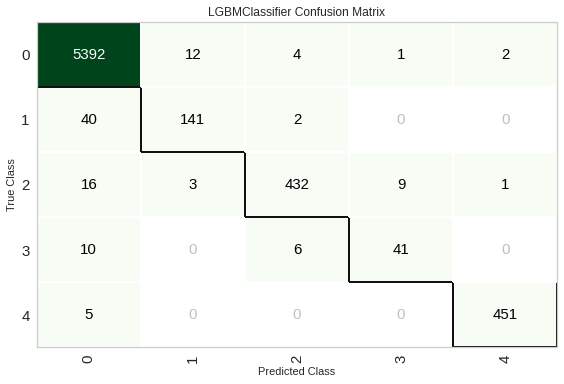

In [37]:
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [38]:
evaluate_model(tuned_lightgbm)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [39]:
# interpret model
interpret_model(tuned_lightgbm, save = True)
grab_pycaret_export('SHAP summary.png', 
                        new_name="lightgbm_Ensemble_MITBIH_interpret.png", 
                        destination=mit_figures.resolve()
                        )

moved file to /content


In [40]:
%%capture
save_model(tuned_lightgbm, model_name=mitbih_outpath/"ensemble_lgbm_mitbih")

### xgboost

In [41]:
xgboost = create_model('xgboost')


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9915  0.9909  0.9231  0.9913  0.9913  0.9717  0.9718   
1       0.9850  0.9791  0.8867  0.9847  0.9846  0.9497  0.9499   
2       0.9870  0.9953  0.8979  0.9867  0.9868  0.9566  0.9566   
3       0.9896  0.9935  0.9527  0.9896  0.9895  0.9654  0.9654   
4       0.9876  0.9910  0.8773  0.9872  0.9871  0.9582  0.9584   
5       0.9902  0.9849  0.9101  0.9901  0.9900  0.9670  0.9672   
6       0.9830  0.9789  0.8641  0.9824  0.9825  0.9431  0.9432   
7       0.9824  0.9961  0.8659  0.9821  0.9820  0.9416  0.9416   
8       0.9837  0.9877  0.8727  0.9837  0.9834  0.9449  0.9453   
9       0.9889  0.9905  0.9260  0.9890  0.9889  0.9629  0.9630   
Mean    0.9869  0.9888  0.8976  0.9867  0.9866  0.9561  0.9562   
Std     0.0031  0.0058  0.0282  0.0031  0.0032  0.0102  0.0102   

      Balanced Accuracy  
Fold                     
0                0.9231  
1                0.8867  
2                0.8979  
3                0.9527  
4                0.8773  
5                0.9101  
6                0.8641  
7                0.8659  
8                0.8727  
9                0.9260  
Mean             0.8976  
Std              0.0282

In [42]:
tuned_xg = tune_model(xgboost)


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  \
Fold                                                             
0       0.9928  0.9909  0.9451  0.9927  0.9927  0.9760  0.9761   
1       0.9870  0.9849  0.8872  0.9867  0.9865  0.9561  0.9563   
2       0.9883  0.9950  0.8999  0.9880  0.9881  0.9607  0.9608   
3       0.9935  0.9936  0.9609  0.9936  0.9933  0.9782  0.9783   
4       0.9889  0.9908  0.8760  0.9886  0.9884  0.9623  0.9627   
5       0.9922  0.9876  0.9286  0.9922  0.9920  0.9736  0.9738   
6       0.9843  0.9825  0.8573  0.9840  0.9835  0.9469  0.9473   
7       0.9876  0.9973  0.8615  0.9874  0.9870  0.9586  0.9587   
8       0.9876  0.9875  0.8898  0.9876  0.9874  0.9582  0.9585   
9       0.9915  0.9969  0.9270  0.9915  0.9914  0.9714  0.9717   
Mean    0.9894  0.9907  0.9033  0.9892  0.9890  0.9642  0.9644   
Std     0.0028  0.0048  0.0337  0.0029  0.0030  0.0096  0.0095   

      Balanced Accuracy  
Fold                     
0                0.9451  
1                0.8872  
2                0.8999  
3                0.9609  
4                0.8760  
5                0.9286  
6                0.8573  
7                0.8615  
8                0.8898  
9                0.9270  
Mean             0.9033  
Std              0.0337

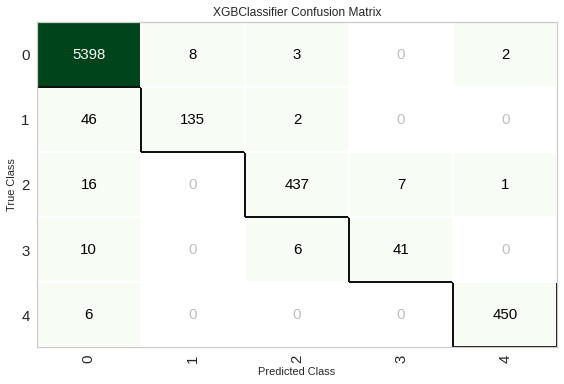

In [43]:
plot_model(tuned_xg, plot = 'confusion_matrix')

In [44]:
evaluate_model(tuned_xg)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [45]:
# interpret model
interpret_model(tuned_xg, save = True)
grab_pycaret_export('SHAP summary.png', 
                        new_name=f"xgboost_Ensemble_MITBIH_interpret.png", 
                        destination=mit_figures.resolve()
                        )

moved file to /content


In [46]:
%%capture
save_model(tuned_xg, model_name=mitbih_outpath/"ensemble_XGboost_mitbih")


## save pycaret experiment

In [47]:
get_logs()
pyc_mit =  pull()


In [48]:
exp_log_out = mitbih_outpath / "mitbih_ensemble_fitting_pycaret_LOGS"
pyc_mit.to_csv(exp_log_out.with_suffix('.csv'))

# lazypredict

- docs are on [pypip here](https://pypi.org/project/lazypredict/)


In [49]:
!pip install lazypredict -q


     |████████████████████████████████| 248 kB 13.8 MB/s 
     |████████████████████████████████| 269 kB 69.5 MB/s 
     |████████████████████████████████| 6.8 MB 74.4 MB/s 
     |████████████████████████████████| 14.5 MB 76.8 MB/s 
     |████████████████████████████████| 302 kB 95.6 MB/s 
     |████████████████████████████████| 1.2 MB 73.4 MB/s 
     |████████████████████████████████| 127.6 MB 1.1 MB/s 
     |████████████████████████████████| 72 kB 1.0 MB/s 
     |████████████████████████████████| 10.1 MB 65.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
tensorflow 2.8.0 requires numpy>=1.20, but you have numpy 1.19.1 which is incompatible.
pycaret 2.3.9 requires scikit-learn==0.23.2, but you have scikit-learn 0.23.1 which is incompatible.
pandas-profiling 3.1

In [50]:
lf_mitbih_df = mitbih_df.copy()
y = lf_mitbih_df.actual_class.values
del lf_mitbih_df["actual_class"]
X = lf_mitbih_df.values
print(X.shape, y.shape)

(21892, 18) (21892,)


In [51]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5,random_state =123)

clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models,predictions = clf.fit(X_train, X_test, y_train, y_test)


100%|██████████| 29/29 [00:37<00:00,  1.28s/it]


In [52]:
import pprint as pp
# pp.pprint(models)

m_df = pd.DataFrame(models).convert_dtypes()
m_df

Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
XGBClassifier                      0.99               0.89    None      0.98   
LGBMClassifier                     0.99               0.89    None      0.98   
BaggingClassifier                  0.98               0.89    None      0.98   
RandomForestClassifier             0.99               0.89    None      0.98   
ExtraTreesClassifier               0.99               0.88    None      0.98   
GaussianNB                         0.94               0.87    None      0.95   
SVC                                0.98               0.87    None      0.98   
DecisionTreeClassifier             0.98               0.87    None      0.98   
LinearDiscriminantAnalysis         0.98               0.86    None      0.98   
ExtraTreeClassifier                0.98               0.86    None      0.98   
LabelPropagation                   0.98               0.85    None      0.98   
LabelSpreading                     0.98               0.85    None      0.98   
KNeighborsClassifier               0.98               0.81    None      0.98   
LogisticRegression                 0.98               0.80    None      0.98   
NearestCentroid                    0.96               0.78    None      0.96   
CategoricalNB                      0.96               0.75    None      0.95   
SGDClassifier                      0.96               0.66    None      0.95   
CalibratedClassifierCV             0.96               0.62    None      0.95   
LinearSVC                          0.96               0.61    None      0.95   
Perceptron                         0.92               0.59    None      0.90   
BernoulliNB                        0.92               0.54    None      0.91   
PassiveAggressiveClassifier        0.89               0.49    None      0.87   
AdaBoostClassifier                 0.88               0.46    None      0.84   
RidgeClassifierCV                  0.91               0.45    None      0.89   
RidgeClassifier                    0.91               0.44    None      0.89   
QuadraticDiscriminantAnalysis      0.01               0.20    None      0.00   
DummyClassifier                    0.70               0.20    None      0.70   

                               Time Taken  
Model                                      
XGBClassifier                        1.38  
LGBMClassifier                       0.61  
BaggingClassifier                    0.14  
RandomForestClassifier               0.65  
ExtraTreesClassifier                 0.70  
GaussianNB                           0.05  
SVC                                  0.73  
DecisionTreeClassifier               0.05  
LinearDiscriminantAnalysis           0.12  
ExtraTreeClassifier                  0.04  
LabelPropagation                     4.97  
LabelSpreading                       6.29  
KNeighborsClassifier                 3.02  
LogisticRegression                   0.74  
NearestCentroid                      0.05  
CategoricalNB                        0.08  
SGDClassifier                        0.20  
CalibratedClassifierCV              12.67  
LinearSVC                            3.56  
Perceptron                           0.10  
BernoulliNB                          0.05  
PassiveAggressiveClassifier          0.12  
AdaBoostClassifier                   0.50  
RidgeClassifierCV                    0.13  
RidgeClassifier                      0.05  
QuadraticDiscriminantAnalysis        0.07  
DummyClassifier                      0.04

In [53]:
try:
    m_df.to_csv(mitbih_outpath / "lazypredict_mitbih.csv")
except Exception as e:
    print(f"Cannot save dataframe with pandas, error:\n{e}")

In [54]:
import joblib

_out_lp_mitbih = Path(mitbih_outpath) / "LP_mitbih_ensemble_baselines_pandas.pkl"
joblib.dump(m_df, filename=_out_lp_mitbih, compress=True)

['/content/drive/MyDrive/ETHZ-2022-S/ML-healthcare-projects/project1/Trained-Results-Analysis/MIT_ensemble/LP_mitbih_ensemble_baselines_pandas.pkl']